# Notebook 1: Data Loading and Preprocessing
## Introduction
# Loads PM2.5 data from OpenAQ API and weather from Open-Meteo. Merges, cleans (handles missing/outliers), and saves CSV.
# Justification: Official APIs for reliable data; merge on timestamp for hourly alignment. Cap PM2.5 at 150.5 µg/m³ (Unhealthy AQI threshold) to handle outliers without bias, preserving data for SDG 11 (urban air quality).

In [1]:
# Mount Google Drive
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Define your project folder in Google Drive
your_project_path = '/content/drive/My Drive/AI_Sustainability_Project_lsa'

# Create the project directory if it doesn't exist
os.makedirs(your_project_path, exist_ok=True)
print(f"Project path set to: {your_project_path}")

# Change current working directory to your project path
%cd "{your_project_path}"

# Verify current working directory
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project path set to: /content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
compression_results_enhanced.csv
compression_summary.html
correlation_matrix_full.csv
evaluation_results_summary.csv
featured_data_for_models.csv
lstm_cm_h12.png
lstm_cm_h1.png
lstm_cm_h24.png
lstm_cm_h3.png
lstm_cm_h6.png
lstm_f16_h6.h5
lstm_model_h12.h5
lstm_model_h1.h5
lstm_model_h24.h5
lstm_model_h3.h5
lstm_model_h6.h5
lstm_original_h6.h5
lstm_tflite_dynamic_h6.tflite
preds_h12.png
preds_h1.png
preds_h24.png
preds_h3.png
preds_h6.png
rf_cm_h12.png
rf_cm_h1.png
rf_cm_h24.png
rf_cm_h3.png
rf_cm_h6.png
rf_feature_selected_h6.pkl
rf_model_h12.pkl
rf_model_h1.pkl
rf_model_h24.pkl
rf_model_h3.pkl
rf_model_h6.pkl
rf_original_h6.pkl
rf_param_reduced_h6.pkl
scaler_x.pkl
scaler_y_h12.p

Ensured 'images' directory exists at /content/drive/MyDrive/AI_Sustainability_Project_lsa/images
--- Starting Data Loading and Preprocessing ---
Attempting to load existing processed data from sensor_12178556_Singapore_pm25_weather_hourly_data_processed_final.csv
Successfully loaded existing data with 'timestamp' as index. Shape: (4073, 10)
Loaded DataFrame index name: timestamp

--- Performing Quick Initial Data Visualizations ---


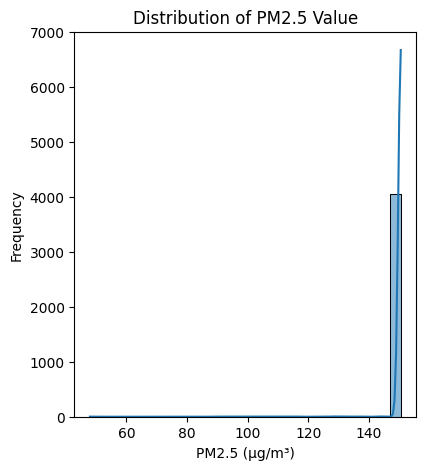

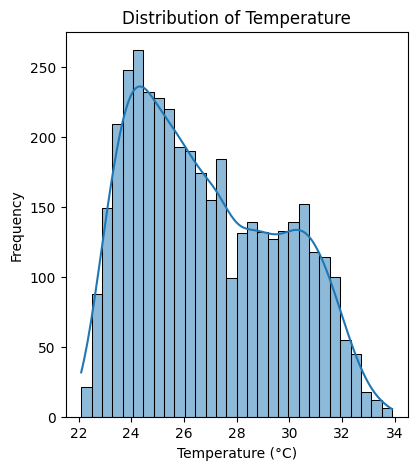

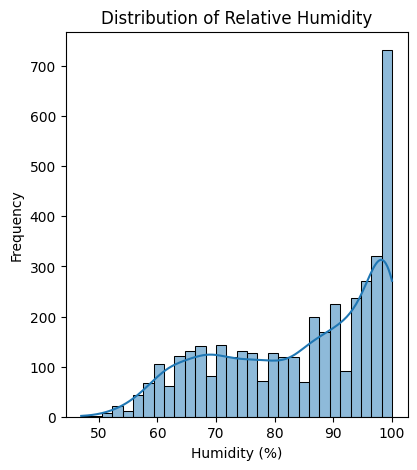

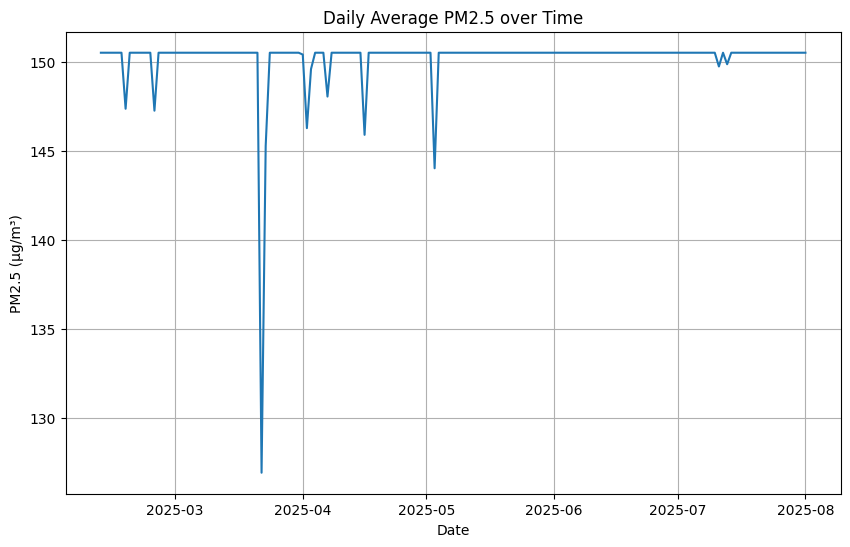


--- Saving Processed Data ---
Processed and cleaned data saved to sensor_12178556_Singapore_pm25_weather_hourly_data_processed_final.csv.
--- Data Loading and Preprocessing Complete ---


In [3]:
import pandas as pd
import numpy as np
import requests
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sensors_id = "12178556"  # Singapore PM2.5 Sensor ID
latitude = 1.3521
longitude = 103.8198
location_name = "Singapore"
openaq_api_key = "4f1e60991c483fd961169d77137baa593d9568f4fa71585725860294b370bc43"  # Replace with actual key

# Define the filename for the processed data
base_processed_file = f'sensor_{sensors_id}_{location_name}_pm25_weather_hourly_data_processed_final.csv'

# --- IMPORTANT: Ensure Google Drive is mounted and project path is set ---
# This part should be in a cell BEFORE this code block, as previously discussed.
# Example:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# your_project_path = '/content/drive/My Drive/AI_Sustainability_Project_lsa'
# os.makedirs(your_project_path, exist_ok=True)
# %cd "{your_project_path}"
# --- END IMPORTANT BLOCK ---

# CRITICAL FIX: Create the 'images' directory if it doesn't exist
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)
print(f"Ensured '{images_dir}' directory exists at {os.getcwd()}/{images_dir}")


print("--- Starting Data Loading and Preprocessing ---")

# Variable to hold the DataFrame, initialized to None
merged_df = None

# --- Attempt to Load Existing Processed Data ---
if os.path.exists(base_processed_file):
    print(f"Attempting to load existing processed data from {base_processed_file}")
    try:
        merged_df = pd.read_csv(base_processed_file, index_col='timestamp', parse_dates=True)
        print(f"Successfully loaded existing data with 'timestamp' as index. Shape: {merged_df.shape}")
        print(f"Loaded DataFrame index name: {merged_df.index.name}")
    except Exception as e:
        print(f"Error loading existing file: {e}")
        print("Proceeding to re-fetch and re-process data.")
        merged_df = None

# --- Data Fetching and Initial Processing (if not loaded from file) ---
if merged_df is None:
    print("Processed data not loaded (either not found or previous load failed). Initiating API data fetch and processing.")

    # --- Fetch PM2.5 Data from OpenAQ API ---
    all_pm25_records = []
    page = 1
    limit_per_page = 1000
    date_from_str = '2022-05-01'
    date_to_str = '2024-04-30'

    print("Fetching PM2.5 data...")
    while True:
        base_url = f"https://api.openaq.org/v3/sensors/{sensors_id}/hours"
        params = {"date_from": date_from_str, "date_to": date_to_str, "limit": limit_per_page, "page": page}
        headers = {"X-API-Key": openaq_api_key}
        try:
            response = requests.get(base_url, params=params, headers=headers, timeout=30)
            response.raise_for_status()
            data = response.json()
            results = data.get('results', [])
            if not results:
                print(f"No more PM2.5 data found or end of data for sensor {sensors_id}.")
                break
            for result in results:
                all_pm25_records.append({'timestamp': result['period']['datetimeFrom']['utc'], 'pm25_value': result['value']})
            print(f"Fetched page {page} of PM2.5 data (total records: {len(all_pm25_records)})")
            page += 1
            time.sleep(1)
        except requests.exceptions.RequestException as e:
            print(f"API request error for PM2.5 data: {e}")
            break
        except Exception as e:
            print(f"An unexpected error occurred during PM2.5 fetch: {e}")
            break

    aq_df_raw = pd.DataFrame(all_pm25_records)
    if not aq_df_raw.empty:
        aq_df_raw['timestamp'] = pd.to_datetime(aq_df_raw['timestamp'], utc=True)
        aq_df_raw.sort_values('timestamp', inplace=True)
        aq_df_raw['pm25_value'] = pd.to_numeric(aq_df_raw['pm25_value'], errors='coerce')

        print("\n--- PM2.5 Data Initial Cleaning & Outlier Capping ---")
        initial_pm25_rows = aq_df_raw.shape[0]
        aq_df_raw.dropna(subset=['pm25_value'], inplace=True)
        print(f"Removed {initial_pm25_rows - aq_df_raw.shape[0]} rows with non-numeric PM2.5 values.")

        initial_pm25_rows = aq_df_raw.shape[0]
        aq_df_raw = aq_df_raw[aq_df_raw['pm25_value'] >= 0]
        print(f"Removed {initial_pm25_rows - aq_df_raw.shape[0]} rows with negative PM2.5 values.")

        PM25_CAP = 150.5
        aq_df_raw['pm25_value'] = np.where(aq_df_raw['pm25_value'] > PM25_CAP, PM25_CAP, aq_df_raw['pm25_value'])
        print(f"Capped PM2.5 values above {PM25_CAP} µg/m³ to {PM25_CAP} µg/m³.")
    else:
        print("No PM2.5 data fetched. Skipping PM2.5 cleaning.")
        merged_df = pd.DataFrame() # Set to empty to skip subsequent steps

    if aq_df_raw.empty:
        print("PM2.5 data is empty after initial processing. Skipping weather fetch and merge.")
        merged_df = pd.DataFrame()


    # --- Fetch Weather Data from Open-Meteo Archive API ---
    weather_url = "https://archive-api.open-meteo.com/v1/archive"
    weather_params = {
        "latitude": latitude, "longitude": longitude,
        "start_date": aq_df_raw['timestamp'].min().strftime('%Y-%m-%d') if not aq_df_raw.empty else date_from_str,
        "end_date": aq_df_raw['timestamp'].max().strftime('%Y-%m-%d') if not aq_df_raw.empty else date_to_str,
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,precipitation",
        "timezone": "UTC"
    }
    print("\nFetching weather data...")
    try:
        response_weather = requests.get(weather_url, params=weather_params, timeout=30)
        response_weather.raise_for_status()
        weather_data = response_weather.json()['hourly']
        weather_df = pd.DataFrame(weather_data)
        weather_df['timestamp'] = pd.to_datetime(weather_df['time'], utc=True)
        weather_df.drop(columns=['time'], inplace=True)
        weather_df.sort_values('timestamp', inplace=True)
        weather_df.rename(columns={
            'temperature_2m': 'temp',
            'relative_humidity_2m': 'humidity',
            'wind_speed_10m': 'wind_speed',
            'wind_direction_10m': 'wind_dir',
            'precipitation': 'precipitation'
        }, inplace=True)
        print(f"Weather data fetched. Shape: {weather_df.shape}")
    except requests.exceptions.RequestException as e:
        print(f"API request error for weather data: {e}")
        weather_df = pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred during weather fetch: {e}")
        weather_df = pd.DataFrame()

    # --- Merge PM2.5 and Weather Data ---
    if not aq_df_raw.empty and not weather_df.empty:
        merged_df = pd.merge(aq_df_raw, weather_df, on='timestamp', how='inner')
        print(f"\nMerged DataFrame shape after inner join: {merged_df.shape}")

        merged_df.set_index('timestamp', inplace=True)
        merged_df.sort_index(inplace=True)
        if merged_df.index.name is None:
             merged_df.index.name = 'timestamp'
        print(f"Timestamp set as index. Current index name: {merged_df.index.name}")

        # --- Handle Missing Values (Interpolation and Final Dropna) ---
        print("\n--- Handling Missing Values in Merged Data ---")
        missing_before_interp = merged_df.isnull().sum()
        print("Missing values before interpolation:")
        print(missing_before_interp[missing_before_interp > 0])

        numerical_cols_to_interp = merged_df.select_dtypes(include=np.number).columns
        merged_df[numerical_cols_to_interp] = merged_df[numerical_cols_to_interp].interpolate(method='linear', limit_direction='both')
        print("Applied linear interpolation to numerical features.")

        initial_rows_after_interp = merged_df.shape[0]
        merged_df.dropna(inplace=True)
        rows_dropped_after_interp = initial_rows_after_interp - merged_df.shape[0]
        if rows_dropped_after_interp > 0:
            print(f"Dropped {rows_dropped_after_interp} rows with remaining NaN values after interpolation.")
        else:
            print("No additional rows dropped after interpolation.")

        print("Missing values after interpolation and final dropna:")
        print(merged_df.isnull().sum().sum())

        # --- Feature Engineering: Time-based Features ---
        print("\n--- Engineering Time-based Features ---")
        merged_df['hour_of_day'] = merged_df.index.hour
        merged_df['day_of_week'] = merged_df.index.dayofweek
        merged_df['month'] = merged_df.index.month
        merged_df['is_weekend'] = ((merged_df.index.dayofweek == 5) | (merged_df.index.dayofweek == 6)).astype(int)
        print("Added 'hour_of_day', 'day_of_week', 'month', 'is_weekend' features.")
    else:
        print("Could not merge dataframes due to empty PM2.5 or weather data. Skipping subsequent steps.")
        merged_df = pd.DataFrame()

# Proceed with visualizations and saving only if merged_df is not empty
if not merged_df.empty:
    # --- Quick Initial Data Exploration (Visualizations for context) ---
    print("\n--- Performing Quick Initial Data Visualizations ---")

    # Plot 1: Distribution of PM2.5 Value
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(merged_df['pm25_value'], bins=30, kde=True)
    plt.title('Distribution of PM2.5 Value')
    plt.xlabel('PM2.5 (µg/m³)')
    plt.ylabel('Frequency')
    plt.savefig('images/plot_0_0.png') # Saving as plot_0_0.png
    plt.show()

    # Plot 2: Distribution of Temperature
    # Ensure this part is consistent if you use subplots, or create new figures
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 2)
    sns.histplot(merged_df['temp'], bins=30, kde=True)
    plt.title('Distribution of Temperature')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.savefig('images/plot_0_1.png') # Saving as plot_0_1.png
    plt.show()

    # Plot 3: Distribution of Relative Humidity (not explicitly included in LaTeX but good to generate)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 3)
    sns.histplot(merged_df['humidity'], bins=30, kde=True)
    plt.title('Distribution of Relative Humidity')
    plt.xlabel('Humidity (%)')
    plt.ylabel('Frequency')
    plt.savefig('images/plot_0_2.png') # Saving as plot_0_2.png
    plt.show()

    # Plot 4: Daily Average PM2.5 over Time
    plt.figure(figsize=(10, 6))
    daily_avg_pm25 = merged_df['pm25_value'].resample('D').mean()
    sns.lineplot(data=daily_avg_pm25)
    plt.title('Daily Average PM2.5 over Time')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.grid(True)
    plt.savefig('images/plot_0_3.png') # Saving as plot_0_3.png
    plt.show()

    # --- Save Processed Data for Next Steps ---
    print("\n--- Saving Processed Data ---")
    merged_df.to_csv(base_processed_file, index=True)
    print(f"Processed and cleaned data saved to {base_processed_file}.")
else:
    print("No data processed or merged. Skipping visualizations and saving.")

print("--- Data Loading and Preprocessing Complete ---")